# Level B
# Pick a dataset and objective

### Dataset:
- Dataset of Nifty Stock prices of Indian companies. ( https://www.kaggle.com/rohanrao/nifty50-stock-market-data  )

### Problem Statement:

- Creating an LSTM Model with a fixed network layout.
- Creating an optimization algorithm to tune the hyperparameters (learning rate, optimizer, etc.) and get higher accuracy of prediction.

### Time Period
- Time period of the  year of 2008 using all previous data and for 2016 using data from 2009-2015.
    
    
    - Algorithm optimizing the model and save it into a file (PKL -- Pickle file).
    - Algorithm also saves the final accuracy results of the model into a "Metrics.csv" file.
    - Creating a serve algorithm that can accept a csv file as input and predict a year's worth of prices for the "Close" value of ASIANPAINTS.



In [29]:
### Loading the libraries required

import pandas as pd       #Loading pandas for creating and adjusting dataframes 
import numpy as np        # Loading Numpy for creating and adjusting arrays

import matplotlib.pyplot as plt      # Loading matplotlib for visualizations
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler # Loading MinMaxScaler to scale the data

from sklearn.model_selection import GridSearchCV, KFold # Loading gridsearch CV for hyperparameter tuning using Crss Validation

from tensorflow.keras.layers import LSTM

from tensorflow.keras.models import Sequential     #Loading Sequential model from tensor flow to craete a LSTM model
from tensorflow.keras.layers import LSTM           #Loading LSTM model from tensor flow to craete a ANN model
from tensorflow.keras.layers import Dense          #Loading Dense layer from tensor flow to craete a Neural network layers
from tensorflow.keras.layers import Dropout        #Loading Drop out Layer

from tensorflow.keras.optimizers import Adam       #Loading Adam optimizer for LSTM

from sklearn.metrics import mean_squared_error     #Loading Mean Squared Error to to check the error metrics of the model 
from sklearn.metrics import mean_absolute_percentage_error  #Loading Mean absolute percentage error to to check the error metrics of the model 
from sklearn.metrics import r2_score       #Loading R^2 (R squared) to check the efficiency metrics of the model


In [30]:
# Get input from user of a file name
csv_file  = input("Enter CSV file name : ")


Enter CSV file name : asianpaint


In [31]:
#Reading the file name given as input
csv_file = csv_file.upper()
file_name = ("{}.csv".format(csv_file))
df = pd.read_csv(file_name)

In [32]:
# Preprocessing the data

def preprocessing(df,year):
    
    df["Date"] = pd.to_datetime(df.Date, format="%d-%m-%Y") #Converting the Date column to datetime fromat
    df["Year"] = pd.to_datetime(df.Date, format="%d-%m-%Y").dt.year # XCreating a Year Column in DF to split the data
    
    ### If year input in 2008
    # Create data between 2000 to 2008
    #Considering only DATE, Closea and Year Column
    
    if year == 2008:
        
        start_year = year-8
        end_year = year
        
        data = df.loc[df["Year"] <= year]
        
        data = data[["Date","Close","Year"]]
        data.set_index('Date', inplace=True)
        
    ### If year input is 2016
    # Create data between 2009 to 2016
    #Considering only DATE, Closea and Year Column
    
    if year == 2016:
        
        start_year = year-7
        end_year = year
    
        data = df[(df["Year"] <= end_year) & (df["Year"] >= start_year)]
        
        data = data[["Date","Close","Year"]]
        data.set_index('Date', inplace=True)
        
    
    # Create Test data and Train data as per inputs given (Input is Year)
    
    Train_data = data.loc[data["Year"] < end_year]
    Train_data = Train_data["Close"]
    Train_data = Train_data.to_frame()
    
    Test_data = data[(data["Year"] == end_year)]
    Test_data = Test_data["Close"]
    Test_data = Test_data.to_frame()
    
    return Train_data,Test_data,data

In [33]:
# Creating Train and Test data with the function created
Train_data = preprocessing(df,2008)[0]
Test_data = preprocessing(df,2008)[1]
data = preprocessing(df,2008)[2]

<AxesSubplot:xlabel='Date'>

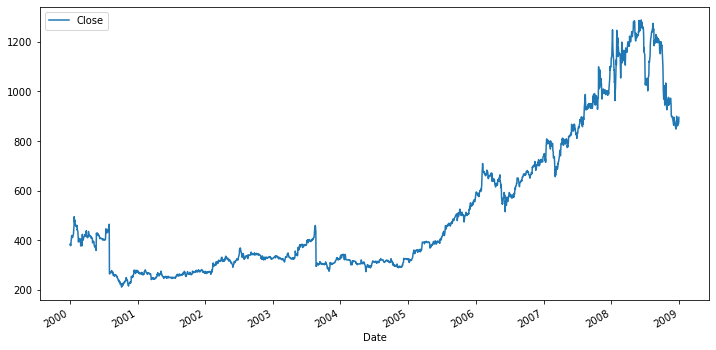

In [34]:
#Visualizing the Close column
data = data.drop(["Year"], axis = 1)
data.plot( y = "Close",figsize=(12,6))

In [35]:
# Scaling the data using MinMaxScaler and fit the tain and test data
scaler = MinMaxScaler(feature_range = (0,1))

scaled_array_train = scaler.fit_transform(Train_data)
scaled_array_test = scaler.fit_transform(Test_data)

In [36]:
# Creating the time series based on time step with the scaled data
## Time step provided is 90

def create_time_series(scaled_array,time_step):
    X = []
    Y = []
    time_step = time_step
    for i in range(time_step,len(scaled_array)):
        X.append(scaled_array[i-time_step:i,0])
        Y.append(scaled_array[i,0])
    
    
    X = np.array(X)
    Y = np.array(Y)
    
    return (X,Y)
    

In [37]:
#Creating X_train,Y_train,X_test,Y_test using the above created function

X_train = create_time_series(scaled_array_train,90)[0]
Y_train = create_time_series(scaled_array_train,90)[1]

X_test = create_time_series(scaled_array_test,90)[0]
Y_test = create_time_series(scaled_array_test,90)[1]


In [38]:
X_train_reshaped = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [39]:
X_test_reshaped = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [40]:
# Creating the function to optimize the Hyper parameters
# In this case learning_rate and dropout_rate

def optimize_params(X,Y):
    #creating model to use in the grid serach CV
    def create_model(learning_rate,dropout_rate):
        model = Sequential()
        model.add(LSTM(50, activation="relu",return_sequences =True, input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.2))

        model.add(LSTM(50, activation="relu",return_sequences =False))
        model.add(Dropout(0.2))

        model.add(Dense(1))
        adam = Adam(learning_rate = learning_rate)
        model.compile(optimizer=adam, loss='mse')
        return model

    # Create the model
    from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
    model = KerasRegressor(build_fn = create_model,verbose = 0,batch_size= 10,epochs = 3)

    # Define the grid search parameters

    learning_rate = [0.001,0.01,0.1]
    dropout_rate = [0.01,0.1,0.2]

    # Make a dictionary of the grid search parameters

    param_grids = dict(learning_rate = learning_rate,
                       dropout_rate = dropout_rate)

    # Build and fit the GridSearchCV

    grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
    grid_result = grid.fit(X,Y)

    # Summarize the results
    print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('{},{} with: {}'.format(mean, stdev, param))
    

    return (grid_result.best_params_)

In [41]:
# Using the function optimize_params to check for optimum values
best_parameters = optimize_params(X_train_reshaped,Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 1/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.002 total time=  24.7s
[CV 2/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 2/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.000 total time=  27.1s
[CV 3/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 3/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.001 total time=  29.0s
[CV 4/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 4/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.000 total time=  23.5s
[CV 5/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 5/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.002 total time=  24.3s
[CV 1/5; 2/9] START dropout_rate=0.01, learning_rate=0.01.......................

C:\Users\cricl\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-0.00092129 -0.00520098         nan -0.00114658 -0.01316921         nan
 -0.00105198 -0.00367798         nan]
  warnings.warn(


Best : -0.0009212948440108448, using {'dropout_rate': 0.01, 'learning_rate': 0.001}
-0.0009212948440108448,0.0005878467216750516 with: {'dropout_rate': 0.01, 'learning_rate': 0.001}
-0.005200981831876561,0.008436541400613833 with: {'dropout_rate': 0.01, 'learning_rate': 0.01}
nan,nan with: {'dropout_rate': 0.01, 'learning_rate': 0.1}
-0.0011465822695754468,0.0005028012908107719 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
-0.013169213902438059,0.023080891840444515 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
nan,nan with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
-0.0010519825736992061,0.0009457506292940278 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
-0.0036779763642698525,0.002956767660286564 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
nan,nan with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


In [57]:
best_parameters

{'dropout_rate': 0.01, 'learning_rate': 0.001}

In [58]:
dropout_rate = 0.01
learning_rate = 0.001

In [59]:
## Creating the ,model using the optimum parameters
model = Sequential()

model.add(LSTM(50, activation="relu",return_sequences =True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(dropout_rate))

model.add(LSTM(50, activation="relu",return_sequences =False))
model.add(Dropout(dropout_rate))
          
model.add(Dense(1))
adam = Adam(learning_rate = learning_rate)

# model compiling using parameters
model.compile(optimizer=adam, loss='mse')

model.summary()
#Fitting the data into the model
hist = model.fit(X_train_reshaped,Y_train,epochs=5,verbose = 2)

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_278 (LSTM)              (None, 90, 50)            10400     
_________________________________________________________________
dropout_278 (Dropout)        (None, 90, 50)            0         
_________________________________________________________________
lstm_279 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_279 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60/60 - 4s - loss: 0.0246
Epoch 2/5
60/60 - 3s - loss: 9.6144e-04
Epoch 3/5
60/60 - 4s - loss: 8.0744e-0

In [61]:
## Creating the H5 file and svaing the model
model.save('{}.h5'.format(csv_file))

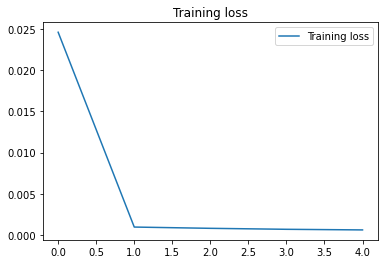

In [62]:
# Plotting the loss function
plt.plot(hist.history['loss'], label='Training loss')
plt.title("Training loss")
plt.legend()

In [63]:
# Predicting the train and test values
train_predict=model.predict(X_train_reshaped)
test_predict=model.predict(X_test_reshaped)

In [64]:
#Inverse transforming the values to regain the unscaled values
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

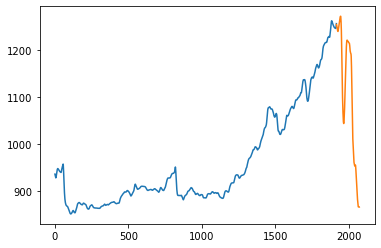

In [65]:
#Plotting the train and test values
day_new=np.arange(len(train_predict))
day_pred=np.arange(len(train_predict),len(train_predict)+len(test_predict))
plt.plot(day_new,train_predict)
plt.plot(day_pred,test_predict)

In [66]:
# Created a function to evaluate the metrics of all the models

def Evaluate_models(model):
    y_pred = model.predict(X_test_reshaped)
    
    MSE = mean_squared_error(Y_test, y_pred)
    
    RMSE = mean_squared_error(Y_test, y_pred, squared=False)

    R2 = r2_score(Y_test, y_pred)
    
    ADJ_R2 = 1 - (1-R2)*(len(Y_train)-1)/(X_train.shape[0]-X_train.shape[1]-1)

    MAPE = mean_absolute_percentage_error(Y_test, y_pred)
    
    return (MSE,RMSE,R2,ADJ_R2,MAPE)

In [67]:
# Loading the metrics into DF using above function
Metrics_LSTM  = Evaluate_models(model)
MSE_LSTM = Metrics_LSTM[0]
RMSE_LSTM = Metrics_LSTM[1]
R2_LSTM = Metrics_LSTM[2]
ADJ_R2_LSTM = Metrics_LSTM[3]
MAPE_LSTM = Metrics_LSTM[4]

In [68]:
Metrics={'Models':["Neural Network"],
      'MSE' :[MSE_LSTM],
      'RMSE' :[RMSE_LSTM],
      'R2' :[R2_LSTM],
      'ADJ R2' :[ADJ_R2_LSTM,],
      'MAPE' :[MAPE_LSTM]
      
   }
Metrics=pd.DataFrame(Metrics)
# Saving the DF into CSV file
Metrics.to_csv("Metrics.csv")

In [69]:
Metrics

,Models,MSE,RMSE,R2,ADJ R2,MAPE
0,Neural Network,0.021758,0.147505,0.788963,0.778561,2.056576e+12
